In [57]:
import tensorflow as tf
keras, L = tf.keras, tf.keras.layers

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from skimage.transform import resize

In [83]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

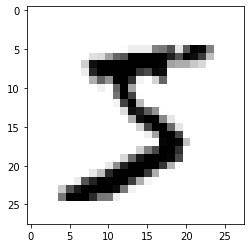

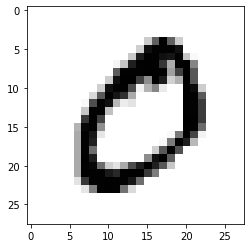

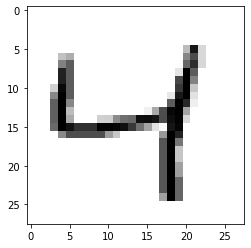

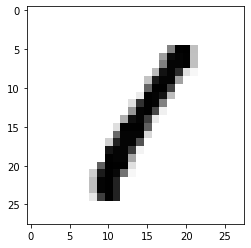

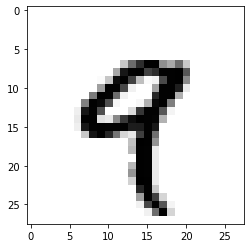

In [84]:
for i in range(5):
    plt.imshow(np.reshape(X[i], (28, 28)), cmap=plt.cm.gray_r)
    plt.show()

In [85]:
train_samples = 5000
test_samples = 1000
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=train_samples, test_size=test_samples, 
                                                    random_state=42)
del X, y

In [86]:
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28))
X_train = np.stack([X_train]*3, axis=-1)
y_train = y_train.astype(int)

X_test = np.reshape(X_test, (X_test.shape[0], 28, 28))
X_test = np.stack([X_test]*3, axis=-1)
y_test = y_test.astype(int)

In [87]:
def resize_image(img):
    img = resize(img, (32, 32), mode='reflect')
    return img

In [88]:
X_train = np.array(list(map(resize_image, X_train)))
X_test = np.array(list(map(resize_image, X_test)))

In [122]:
def init_block(x, filters, kernel_size):
    x = L.Conv2D(filters=filters, kernel_size=kernel_size, 
                 input_shape=input_shape, padding="SAME")(x)
    return x

In [133]:
def f(x, filters):
    x = L.BatchNormalization(axis=3)(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(filters=filters, kernel_size=3, padding="SAME")(x)
    x = L.BatchNormalization(axis=3)(x)
    x = L.Activation("relu")(x)
    x = L.Conv2D(filters=filters, kernel_size=3, padding="SAME")(x)
    
    return x

def rev_block(x, filters):
    x1, x2 = tf.split(x, num_or_size_splits=2, axis=3)
    y1 = f(x2, filters // 2) + x1
    y2 = f(y1, filters // 2) + x2

    return tf.concat([y1, y2], axis=3)

Модель с Reversible блоком, но в конце которой находятся Dense слои:

In [134]:
input_shape = X_train.shape[1:]
filters = 32
init_kernel = 5
n_rev_blocks = 1
n_classes = 10

img_input = L.Input(input_shape)
x = init_block(img_input, filters, init_kernel)
for _ in range(n_rev_blocks):
    x = rev_block(x, filters)
x = L.Flatten()(x)

x = L.Dense(100)(x)
x = L.Activation("relu")(x)
x = L.Dense(n_classes)(x)
x = L.Activation("softmax")(x)

model = keras.Model(img_input, x)

In [135]:
model.summary()

Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 32, 32, 32)   2432        input_35[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_split_31 (TensorFlo [(None, 32, 32, 16), 0           conv2d_171[0][0]                 
__________________________________________________________________________________________________
batch_normalization_113 (BatchN (None, 32, 32, 16)   64          tf_op_layer_split_31[0][1]       
___________________________________________________________________________________________

In [136]:
adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(X_train, y_train,
          batch_size=32, epochs=20, 
          validation_data=(X_test, y_test))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 19s 4ms/sample - loss: 14.6231 - sparse_categorical_accuracy: 0.5372 - val_loss: 1.8448 - val_sparse_categorical_accuracy: 0.4600
Epoch 2/20
5000/5000 [==============================] - 19s 4ms/sample - loss: 1.5324 - sparse_categorical_accuracy: 0.5168 - val_loss: 1.5437 - val_sparse_categorical_accuracy: 0.5840
Epoch 3/20
5000/5000 [==============================] - 19s 4ms/sample - loss: 1.3685 - sparse_categorical_accuracy: 0.5866 - val_loss: 1.8652 - val_sparse_categorical_accuracy: 0.5440
Epoch 4/20
5000/5000 [==============================] - 19s 4ms/sample - loss: 1.2856 - sparse_categorical_accuracy: 0.6038 - val_loss: 1.4918 - val_sparse_categorical_accuracy: 0.6090
Epoch 5/20
5000/5000 [==============================] - 19s 4ms/sample - loss: 1.2270 - sparse_categorical_accuracy: 0.6170 - val_loss: 1.3585 - val_sparse_categorical_accuracy: 0.6090
Epoch 6/20
5000/5000 [====

Модель с Reversible блоком, где в конце выбирается 10 чисел из равномерной сетки:

In [137]:
input_shape = [32, 32, 3]
filters = 32
init_kernel = 5
n_rev_blocks = 1
n_classes = 10

img_input = L.Input(input_shape)
x = init_block(img_input, filters, init_kernel)
for _ in range(n_rev_blocks):
    x = rev_block(x, filters)
x = L.Flatten()(x)

positions = tf.range(0, x.shape[-1], x.shape[-1] // n_classes + 1)
x = tf.reshape(tf.convert_to_tensor([x[:, i] for i in positions]), (-1, n_classes))
x = L.Activation("softmax")(x)

model = keras.Model(img_input, x)

In [138]:
model.summary()

Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_176 (Conv2D)             (None, 32, 32, 32)   2432        input_36[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_split_32 (TensorFlo [(None, 32, 32, 16), 0           conv2d_176[0][0]                 
__________________________________________________________________________________________________
batch_normalization_117 (BatchN (None, 32, 32, 16)   64          tf_op_layer_split_32[0][1]       
___________________________________________________________________________________________

In [139]:
adam = keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.fit(X_train, y_train,
          batch_size=32, epochs=20, 
          validation_data=(X_test, y_test))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 17s 3ms/sample - loss: 7.3143 - sparse_categorical_accuracy: 0.0954 - val_loss: 4.7881 - val_sparse_categorical_accuracy: 0.0900
Epoch 2/20
5000/5000 [==============================] - 17s 3ms/sample - loss: 3.7155 - sparse_categorical_accuracy: 0.0976 - val_loss: 3.1764 - val_sparse_categorical_accuracy: 0.1040
Epoch 3/20
5000/5000 [==============================] - 18s 4ms/sample - loss: 3.3309 - sparse_categorical_accuracy: 0.1020 - val_loss: 3.0276 - val_sparse_categorical_accuracy: 0.1180
Epoch 4/20
5000/5000 [==============================] - 18s 4ms/sample - loss: 3.1780 - sparse_categorical_accuracy: 0.1004 - val_loss: 2.9744 - val_sparse_categorical_accuracy: 0.1010
Epoch 5/20
5000/5000 [==============================] - 17s 3ms/sample - loss: 3.0422 - sparse_categorical_accuracy: 0.1030 - val_loss: 2.9319 - val_sparse_categorical_accuracy: 0.1110
Epoch 6/20
5000/5000 [=====